<a href="https://colab.research.google.com/github/kaushikabhishek87/Tensorflow_projects/blob/main/06_transfer_learning_with_Tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
### Using all classes in (101) Food101 Data 

In [1]:
! nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [2]:
## Helper Fucntions
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2021-06-25 12:52:31--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2021-06-25 12:52:31 (99.2 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [3]:
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir, make_confusion_matrix

In [4]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip

unzip_data("101_food_classes_10_percent.zip")

--2021-06-25 12:52:36--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.8.16, 172.217.13.80, 172.217.13.240, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.8.16|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip’

101_food_classes_10 100%[===================>]   1.51G   114MB/s    in 15s     

2021-06-25 12:52:51 (105 MB/s) - ‘101_food_classes_10_percent.zip’ saved [1625420029/1625420029]



In [5]:
walk_through_dir("101_food_classes_10_percent")

There are 2 directories and 0 images in '101_food_classes_10_percent'.
There are 101 directories and 0 images in '101_food_classes_10_percent/test'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/creme_brulee'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/cheese_plate'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/breakfast_burrito'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/cheesecake'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/bruschetta'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/scallops'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/miso_soup'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/carrot_cake'.
There are 0 directories and 250 image

In [6]:
train_dir = "101_food_classes_10_percent/train"
test_dir = "101_food_classes_10_percent/test"

In [7]:
# Ste up data inputs
import tensorflow as tf

IMG_SIZE = (224,224)
BATCH_SIZE = 32
train_data_all_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                    label_mode="categorical"
                                                                    ,image_size = IMG_SIZE
                                                                    , batch_size=BATCH_SIZE)
                                                                    
test_data =  tf.keras.preprocessing.image_dataset_from_directory(directory = test_dir,
                                                                   label_mode="categorical",
                                                                   image_size=IMG_SIZE,
                                                                   batch_size=BATCH_SIZE,
                                                                    shuffle=False) # For prediction analysis  

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


In [8]:
checkpoint_path = "101_food_classes_10_percent_data_model_checkpoint"
checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                       save_best_only=True,
                                                       save_weights_only=True,
                                                       monitor="accuracy")

In [9]:

# create data augmentatio layer
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

In [ ]:
data_augmentation = Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    preprocessing.RandomZoom(0.2)
], name = "data_augmentation")

base_model = tf.keras.applications.EfficientNetB0(include_top=False)

base_model.trainable=False

# Model Acrh
inputs = layers.Input(shape=(224,224,3), name="input_layer")

X = data_augmentation(inputs)

X = base_model(X, training=False)

X = layers.GlobalAveragePooling2D(name="global_average_pool2D")(X)

outputs = layers.Dense(101, activation="softmax", name="output_layer")(X)

model = tf.keras.Model(inputs, outputs)


16711680/16705208 [==============================] - 0s 0us/step


In [ ]:
model.summary() 

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
data_augmentation (Sequentia (None, None, None, 3)     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_average_pool2D (Globa (None, 1280)              0         
_________________________________________________________________
output_layer (Dense)         (None, 101)               129381    
Total params: 4,178,952
Trainable params: 129,381
Non-trainable params: 4,049,571
_________________________________________________________________


In [ ]:
model.compile(loss="categorical_crossentropy",
              optimizer="Adam",
              metrics=["accuracy"])

history_all_classes_10_percent = model.fit(train_data_all_10_percent,
          epochs=5,
          steps_per_epoch=len(train_data_all_10_percent), 
          validation_data = test_data,
          validation_steps=int(0.15* len(test_data)),
          callbacks=[checkpoint_callback])

Epoch 1/5
237/237 [==============================] - 121s 364ms/step - loss: 3.4675 - accuracy: 0.2433 - val_loss: 2.6744 - val_accuracy: 0.4092
Epoch 2/5
237/237 [==============================] - 72s 300ms/step - loss: 2.3523 - accuracy: 0.4564 - val_loss: 2.2481 - val_accuracy: 0.4642
Epoch 3/5
237/237 [==============================] - 64s 267ms/step - loss: 1.9904 - accuracy: 0.5253 - val_loss: 2.0708 - val_accuracy: 0.4876
Epoch 4/5
237/237 [==============================] - 61s 256ms/step - loss: 1.7608 - accuracy: 0.5703 - val_loss: 1.9733 - val_accuracy: 0.5058
Epoch 5/5
237/237 [==============================] - 59s 247ms/step - loss: 1.6058 - accuracy: 0.6017 - val_loss: 1.9262 - val_accuracy: 0.5019


In [ ]:
fine_tuning_results = model.evaluate(test_data)
fine_tuning_results


790/790 [==============================] - 86s 109ms/step - loss: 1.7106 - accuracy: 0.5551


[1.7105611562728882, 0.5550891160964966]

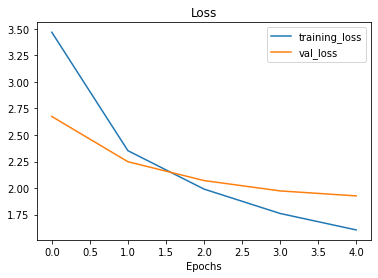

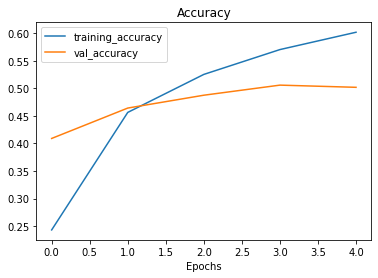

In [ ]:
plot_loss_curves(history_all_classes_10_percent)

In [ ]:
# Fine Tuning

In [ ]:
# Unfreeze layers

base_model.trainable = True

for layer in base_model.layers[:-5]:
  layer.trainable=False


In [ ]:
for i, layer in enumerate(base_model.layers):
  print(i, layer.name, layer.trainable)

0 input_1 False
1 rescaling False
2 normalization False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_reshape F

In [ ]:
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(0.0001),
              metrics=["accuracy"])

fine_tuning_epochs = 10 # Model has already done 5 epochs

history_all_classes_10_percent_fine_tune = model.fit(train_data_all_10_percent,epochs=fine_tuning_epochs ,
          initial_epoch=history_all_classes_10_percent.epoch[-1] ,
          validation_data = test_data , 
          validation_steps = int(0.15*len(test_data)))

Epoch 5/10
237/237 [==============================] - 66s 249ms/step - loss: 1.3648 - accuracy: 0.6470 - val_loss: 1.8471 - val_accuracy: 0.5143
Epoch 6/10
237/237 [==============================] - 55s 230ms/step - loss: 1.2379 - accuracy: 0.6743 - val_loss: 1.8721 - val_accuracy: 0.5090
Epoch 7/10
237/237 [==============================] - 52s 218ms/step - loss: 1.1599 - accuracy: 0.6956 - val_loss: 1.8541 - val_accuracy: 0.5114
Epoch 8/10
237/237 [==============================] - 53s 221ms/step - loss: 1.0834 - accuracy: 0.7142 - val_loss: 1.8386 - val_accuracy: 0.5204
Epoch 9/10
237/237 [==============================] - 50s 212ms/step - loss: 1.0169 - accuracy: 0.7302 - val_loss: 1.8470 - val_accuracy: 0.5175
Epoch 10/10
237/237 [==============================] - 51s 213ms/step - loss: 0.9619 - accuracy: 0.7395 - val_loss: 1.8784 - val_accuracy: 0.5132


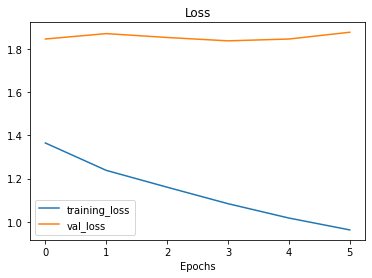

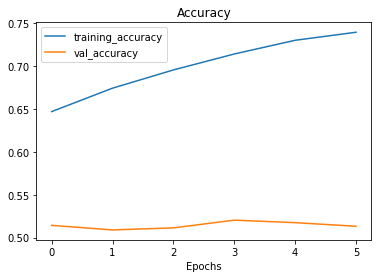

In [ ]:
plot_loss_curves(history_all_classes_10_percent_fine_tune)

In [ ]:
all_classes_10_percent_fine_tuning_results = model.evaluate(test_data)
all_classes_10_percent_fine_tuning_results


790/790 [==============================] - 86s 109ms/step - loss: 1.6082 - accuracy: 0.5769


[1.6081777811050415, 0.5768712759017944]

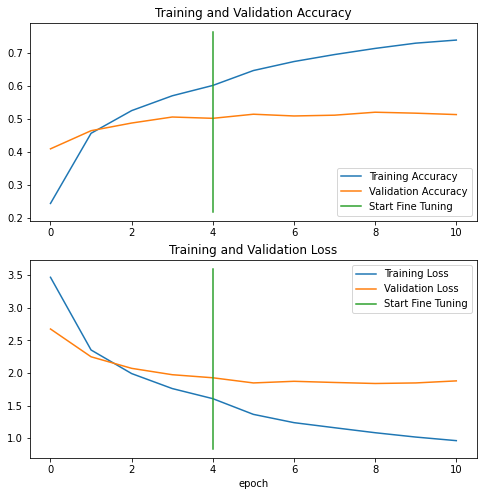

In [ ]:
compare_historys(history_all_classes_10_percent, history_all_classes_10_percent_fine_tune)

In [ ]:
model.save("101_food_classes_10_percent_saved_big_dog_model")

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: 101_food_classes_10_percent_saved_big_dog_model/assets


In [ ]:
!zip -r /content/101_food_classes_10_percent_saved_big_dog_model.zip /content/101_food_classes_10_percent_saved_big_dog_model

  adding: content/101_food_classes_10_percent_saved_big_dog_model/ (stored 0%)
  adding: content/101_food_classes_10_percent_saved_big_dog_model/variables/ (stored 0%)
  adding: content/101_food_classes_10_percent_saved_big_dog_model/variables/variables.data-00000-of-00001 (deflated 8%)
  adding: content/101_food_classes_10_percent_saved_big_dog_model/variables/variables.index (deflated 74%)
  adding: content/101_food_classes_10_percent_saved_big_dog_model/assets/ (stored 0%)
  adding: content/101_food_classes_10_percent_saved_big_dog_model/keras_metadata.pb (deflated 96%)
  adding: content/101_food_classes_10_percent_saved_big_dog_model/saved_model.pb (deflated 92%)


In [ ]:
loaded_model = tf.keras.models.load_model("101_food_classes_10_percent_saved_big_dog_model")

In [ ]:
# Evaluate loaded model
loaded_model_results = loaded_model.evaluate(test_data)

790/790 [==============================] - 88s 110ms/step - loss: 1.6082 - accuracy: 0.5769


In [ ]:
all_classes_10_percent_fine_tuning_results, loaded_model_results

([1.6081777811050415, 0.5768712759017944],
 [1.6081777811050415, 0.5768712759017944])

In [ ]:
# Evaluate Model across different categories

In [10]:
import tensorflow as tf

# Downloading pre trained model for matching results 
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip


--2021-06-25 12:53:38--  https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.164.176, 142.250.81.208, 172.217.2.112, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.164.176|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 46760742 (45M) [application/zip]
Saving to: ‘06_101_food_class_10_percent_saved_big_dog_model.zip’

06_101_food_class_1 100%[===================>]  44.59M   222MB/s    in 0.2s    

2021-06-25 12:53:38 (222 MB/s) - ‘06_101_food_class_10_percent_saved_big_dog_model.zip’ saved [46760742/46760742]



In [11]:
unzip_data("06_101_food_class_10_percent_saved_big_dog_model.zip")

In [12]:
model = tf.keras.models.load_model("06_101_food_class_10_percent_saved_big_dog_model")

In [13]:
results_downloaded_model = model.evaluate(test_data)
results_downloaded_model

790/790 [==============================] - 1129s 1s/step - loss: 1.8027 - accuracy: 0.6078


[1.802719235420227, 0.6077623963356018]

In [14]:
## making prediction
pred_probs = model.predict(test_data, verbose=1)

790/790 [==============================] - 1122s 1s/step


In [26]:
len(pred_probs), pred_probs.shape

(25250, (25250, 101))

In [27]:
# First prediction prob
pred_probs[0], len(pred_probs[0]), sum(pred_probs[0])

(array([5.95416836e-02, 3.57428826e-06, 4.13775034e-02, 1.06607523e-09,
        8.16161005e-09, 8.66415917e-09, 8.09286178e-07, 8.56529311e-07,
        1.98594207e-05, 8.09792596e-07, 3.17283311e-09, 9.86754685e-07,
        2.85326882e-04, 7.80504827e-10, 7.42311066e-04, 3.89169145e-05,
        6.47421211e-06, 2.49777895e-06, 3.78914010e-05, 2.06786510e-07,
        1.55386806e-05, 8.15082956e-07, 2.62308754e-06, 2.00108815e-07,
        8.38293261e-07, 5.42168846e-06, 3.73914031e-06, 1.31505757e-08,
        2.77616247e-03, 2.80520071e-05, 6.85631552e-10, 2.55751092e-05,
        1.66892220e-04, 7.64089902e-10, 4.04536608e-04, 1.31508768e-08,
        1.79577773e-06, 1.44484000e-06, 2.30629742e-02, 8.24686140e-07,
        8.53668610e-07, 1.71385364e-06, 7.05265393e-06, 1.84022948e-08,
        2.85536601e-07, 7.94853077e-06, 2.06820914e-06, 1.85254066e-07,
        3.36205197e-08, 3.15226847e-04, 1.04110459e-05, 8.54501081e-07,
        8.47418129e-01, 1.05555300e-05, 4.40947218e-07, 3.740437

In [28]:
print(f"Number of Prediction Prob for smaple 0 : {len(pred_probs[0])}")
print(f"Class with highest probability for smaple 0 : {(test_data.class_names[pred_probs[0].argmax()])}")

Number of Prediction Prob for smaple 0 : 101
Class with highest probability for smaple 0 : gyoza


In [29]:
pred_classes = pred_probs.argmax(axis=1)
pred_classes[0:10], len(pred_classes)

(array([52,  0,  0, 80, 79, 61, 29,  0, 85,  0]), 25250)

In [30]:
# Getting Test data labels
y_labels=[]
for images, labels in test_data.unbatch():
  y_labels.append(labels.numpy().argmax()) # Currently labels are in one hot encoding shape, so getting position of "1" in [0,0,0,0,1,...] for label value

In [ ]:
len(y_labels), y_labels[:10]

In [ ]:
from sklearn.metrics import classification_report, accuracy_score, precision_score, f1_score

In [ ]:
accuracy_score(y_labels, pred_classes)

In [ ]:
precision_score(y_labels, pred_classes, average="micro")

In [ ]:
# åmake_confusion_matrix(y_true = y_labels, y_pred = pred_classes, classes=test_data.class_names, figsize=(100,100), text_size=20 )

In [31]:
## For this even comparison we put shuffle to FALSE in test data set (so that we can compare with pred labels )
print(classification_report(y_true=y_labels,y_pred=pred_classes ))

              precision    recall  f1-score   support

           0       0.29      0.20      0.24       250
           1       0.51      0.69      0.59       250
           2       0.56      0.65      0.60       250
           3       0.74      0.53      0.62       250
           4       0.73      0.43      0.54       250
           5       0.34      0.54      0.42       250
           6       0.67      0.79      0.72       250
           7       0.82      0.76      0.79       250
           8       0.40      0.37      0.39       250
           9       0.62      0.44      0.51       250
          10       0.62      0.42      0.50       250
          11       0.84      0.49      0.62       250
          12       0.52      0.74      0.61       250
          13       0.56      0.60      0.58       250
          14       0.56      0.59      0.57       250
          15       0.44      0.32      0.37       250
          16       0.45      0.75      0.57       250
          17       0.37    

In [ ]:
test_data.unbatch()